# 참고문서
- https://github.com/JayAhn0104/Recommender-System-PyTorch
- https://colab.research.google.com/drive/1OFQ_yWmjNZScot-qxvkP-cYGI9sHHFtt?usp=sharing#scrollTo=rR7VNlqilKev

# [[Pytorch] Neural Collaborative Filtering](https://github.com/yihong-chen/neural-collaborative-filtering/blob/master/src/train.py)

## Matrix Factorization의 문제점

- MF(Matrix Factorization)는 두 벡터(user의 latent vector, item의 latent vector)의 내적에 의해 ŷ(predicted rating)가 계산된다.    
- 단순 선형 결합을 통해 ŷ을 구하기 때문에 user-item의 복잡한 상호작용을 온전히 표현할 수 없다. 아래 그림은 이런 MF의 표현력의 한계를 나타낸 그림이다.    

따라서 이런 단점을 해결하기 위해 선형결합 대신 Deep Neural Networks를 사용한다.

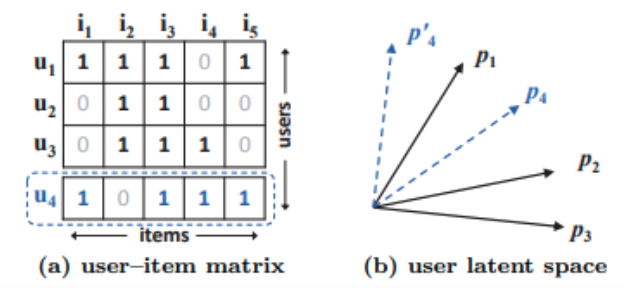

## NCF 모델 구조

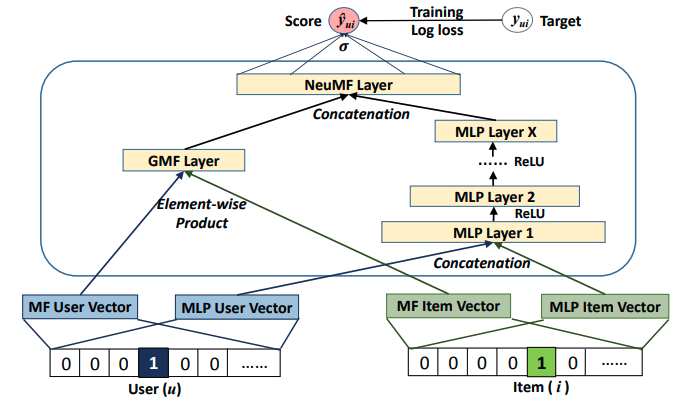

- Input Layer      
유저와 아이템의 ID를 one-hot-encoding하여 sparse한 vector로 변환하여 Input으로 사용한다.   
- Embedding Layer      
Sparse한 one-hot-encoding 데이터를 Dense한 벡터로 바꿔준다. 이렇게 얻어진 dense vector는 Latent vector로도 볼 수 있다.
- Output Layer     
NCF layer와 hidden vector를 input으로 받아 predictive score $ŷ_{ui}$를 예측하며, Target $ŷ_{ui}$와의 비교를 통해 학습이 진행됩니다.  
- Multi-Layer Perceptron Layer        
임베딩이 완료된 User, Item latent vector는 여러 층의 신경망을 거치게 됩니다. 이 다층 신경망 구조를 MLP Layers라고 합니다.    
우선 User latent vector와 Item latent vector를 concatenate한 벡터를 시작으로 각각의 층을 거치며 인공신경망을 통해 복잡한 비선형의 데이터 관계를 학습할 수 있게 됩니다.
- Generalized Matrix Factorization        
Matrix Factorization는 NCF의 특별한 케이스가 됨을 보여주며 이를 GMF라고 명명하였다.

# Dataset - MovieLens

In [ ]:
from google.colab import drive
drive.mount('/content/data')

Mounted at /content/data


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import easydict
import json

args = easydict.EasyDict()
args.default_path = '/content/data/MyDrive/google_lecture/06. deep learning/4. RS Pytorch/data/Movie/ml-1m/'
args.ratings = args.default_path+'ratings.csv'

In [ ]:
ratings = pd.read_csv(args.ratings)

print(f'{ratings.shape}')
ratings.head()

(100004, 4)


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
ratings.describe()

,userId,movieId,rating,timestamp
count,100004.000000,100004.000000,100004.000000,1.000040e+05
mean,347.011310,12548.664363,3.543608,1.129639e+09
std,195.163838,26369.198969,1.058064,1.916858e+08
min,1.000000,1.000000,0.500000,7.896520e+08
25%,182.000000,1028.000000,3.000000,9.658478e+08
50%,367.000000,2406.500000,4.000000,1.110422e+09
75%,520.000000,5418.000000,4.000000,1.296192e+09
max,671.000000,163949.000000,5.000000,1.476641e+09


## Load Datas

In [ ]:
import random

class LoadData(object):

  def __init__(self, args):
    self.ratings = self.__load_ratings(args.ratings)
    self.__binarize()

    self.user_pool = set(self.ratings['uid'].unique())
    self.item_pool = set(self.ratings['iid'].unique())

    self.negatives = self.__sample_negative()
    self.train_ratings, self.test_ratings = self.__split_loop()

  def __load_ratings(self, ratings_path):
    # 파일 통해서 데이터 로드....
    df_ratings = pd.read_csv(ratings_path)
    df_ratings.drop_duplicates(inplace=True) # 중복 제거

    # uid: 새로운 user_id 생성
    df_users = df_ratings[['userId']].drop_duplicates().reindex()

    df_users['uid'] = np.arange(len(df_users))

    df_ratings = pd.merge(df_ratings, df_users, on=['userId'], how='left')
    # iid: 새로운 item_id 생성
    df_items = df_ratings[['movieId']].drop_duplicates().reindex()
    df_items['iid'] = np.arange(len(df_items))
    df_ratings = pd.merge(df_ratings, df_items, on=['movieId'], how='left')

    return df_ratings[['uid', 'iid', 'rating', 'timestamp']]

  def __binarize(self):
    """
    binarize into 0 or 1, implicit feedback
    """
    self.ratings['rating'][self.ratings['rating'] > 0] = 1.0

  def __sample_negative(self, num_ng=99):
    """
    return alll negative items & sampled negative items
    """
    # interacted_iid: 사용자별 시청 영화리스트
    interact_status = self.ratings.groupby(['uid'])['iid'].apply(set).reset_index().rename(
        columns={'iid':'interacted_iid'}
    )
    # negative_iid: 사용자별 시청하지 않은 영화 리스트
    interact_status['negative_iid'] = interact_status['interacted_iid'].map(lambda x: self.item_pool - x)
    # negative_samples: 사용자별 똑같은 크기의 시청하지 않은 영화 리스트
    interact_status['negative_samples'] = interact_status['negative_iid'].map(lambda x: random.sample(x, num_ng))
    return interact_status[['uid', 'negative_iid', 'negative_samples']]

  def __split_loop(self):
    self.ratings['rank_latest'] = self.ratings.groupby(['uid'])['timestamp'].rank(method='first', ascending=False)
    test = self.ratings[self.ratings['rank_latest'] == 1]
    train = self.ratings[self.ratings['rank_latest'] > 1]

    assert train['uid'].nunique() == test['uid'].nunique()
    return train[['uid', 'iid', 'rating']], test[['uid', 'iid', 'rating']]


In [ ]:
loaddata = LoadData(args)

<ipython-input-7-4a6da7331c55>:50: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  interact_status['negative_samples'] = interact_status['negative_iid'].map(lambda x: random.sample(x, num_ng))


In [ ]:
loaddata.ratings.head()

,uid,iid,rating,timestamp,rank_latest
0,0,0,1.0,1260759144,13.0
1,0,1,1.0,1260759179,10.0
2,0,2,1.0,1260759182,9.0
3,0,3,1.0,1260759185,8.0
4,0,4,1.0,1260759205,1.0


In [ ]:
loaddata.test_ratings.shape

(671, 3)

In [ ]:
loaddata.test_ratings.head()

,uid,iid,rating
4,0,4,1.0
66,1,66,1.0
110,2,102,1.0
231,3,206,1.0
414,4,353,1.0


In [ ]:
loaddata.train_ratings.shape

(99333, 3)

In [ ]:
loaddata.train_ratings.head()

,uid,iid,rating
0,0,0,1.0
1,0,1,1.0
2,0,2,1.0
3,0,3,1.0
5,0,5,1.0


In [ ]:
loaddata.train_ratings['rating'].value_counts()

rating
1.0    99333
Name: count, dtype: int64

In [ ]:
loaddata.train_ratings['uid'].nunique()

671

In [ ]:
loaddata.negatives.head()

,uid,negative_iid,negative_samples
0,0,"{20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 3...","[4990, 1975, 1674, 7826, 2815, 793, 8134, 5005..."
1,1,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[2741, 2929, 8338, 365, 7857, 4939, 549, 5771,..."
2,2,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[3310, 1477, 7920, 7990, 5124, 6545, 2571, 527..."
3,3,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 14, 16, 17,...","[5523, 864, 7935, 978, 5321, 5794, 8828, 596, ..."
4,4,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[5192, 3822, 3271, 7118, 2793, 8149, 3687, 203..."


## Dataset

In [ ]:
import torch
from torch.utils.data import Dataset

In [ ]:
class RatingDataset(Dataset):
  def __init__(self, data, negative, num_ng=4):

    concat_ratings = self.__add_negative_items(data, negative, num_ng)

    self.features = concat_ratings[['uid','iid']].to_numpy().astype(np.longlong)
    self.field_dims = np.max(self.features, axis=0) + 1

    self.features = torch.from_numpy(self.features)
    self.labels = torch.from_numpy(concat_ratings['rating'].to_numpy().astype(np.float32))

  def __add_negative_items(self, data, negative, num_ng):
    negative['negatives'] = negative['negative_iid'].map(lambda x: random.sample(x, num_ng))
    negative = negative[['uid', 'negatives']].explode('negatives').rename(
        columns={'negatives':'iid'}
    )
    negative['rating'] = 0.0
    return pd.concat([data, negative], axis=0)

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):
    return self.features[index], self.labels[index]

In [ ]:
train_dataset = RatingDataset(loaddata.train_ratings, loaddata.negatives)
test_dataset = RatingDataset(loaddata.test_ratings, loaddata.negatives)

len(train_dataset), len(test_dataset)

<ipython-input-31-453f61c45e34>:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  negative['negatives'] = negative['negative_iid'].map(lambda x: random.sample(x, num_ng))
<ipython-input-31-453f61c45e34>:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  negative['negatives'] = negative['negative_iid'].map(lambda x: random.sample(x, num_ng))


(102017, 3355)

In [ ]:
feture, rating = next(iter(train_dataset))
feture, rating

(tensor([0, 0]), tensor(1.))

In [ ]:
feture, rating = next(iter(train_dataset))
feture, rating

(tensor([0, 0]), tensor(1.))

In [ ]:
train_dataset.field_dims

array([ 671, 9066], dtype=int64)

In [ ]:
len(loaddata.user_pool), len(loaddata.item_pool)

(671, 9066)

## Data Loader

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
train_loader = DataLoader(
    train_dataset, batch_size=1024, shuffle=True
)

test_loader = DataLoader(
    test_dataset, batch_size=1024, shuffle=False
)

In [ ]:
len(train_loader), len(test_loader)

(100, 4)

In [ ]:
features, target = next(iter(train_loader))
features, target

(tensor([[  58, 3562],
         [ 127,  278],
         [ 400, 2998],
         ...,
         [ 217,  119],
         [ 623,  109],
         [ 333,   57]]),
 tensor([1., 1., 1.,  ..., 1., 1., 1.]))

# NCF Model

- [offset](https://hiddenbeginner.github.io/deeplearning/2020/01/21/pytorch_tensor.html)      
offset 은 텐서의 첫 번째 원소가 storage에 저장되어 있는 인덱스이다.

In [ ]:
import torch

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
field_dims = train_dataset.field_dims
field_dims

array([ 671, 9066], dtype=int64)

In [ ]:
features, label = next(iter(train_loader))
features.shape, label.shape

(torch.Size([1024, 2]), torch.Size([1024]))

## FeaturesEmbedding

In [ ]:
class FeaturesEmbedding(torch.nn.Module):

    def __init__(self, field_dims, embed_dim):
        super().__init__()
        self.embedding = torch.nn.Embedding(sum(field_dims), embed_dim)
        self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.float32) # offsets: 사용자 아이디의 시작 인덱스, 아이템 아이디의 시작 인덱스
        torch.nn.init.xavier_uniform_(self.embedding.weight.data) # embedding 가중치 초기화

    def forward(self, x):
        """
        :param x: Long tensor of size ``(batch_size, num_fields)``
        """
        x = x + x.new_tensor(self.offsets).unsqueeze(0)
        return self.embedding(x)

- 디버깅

In [ ]:
embedding = torch.nn.Embedding(sum(field_dims), 16)

In [ ]:
offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.float32)
offsets

array([  0., 671.], dtype=float32)

In [ ]:
print(features.shape)
features

torch.Size([1024, 2])


tensor([[  18,  777],
        [ 213,   69],
        [ 486,   75],
        ...,
        [ 451, 7244],
        [ 293, 6110],
        [ 546,   92]])

In [ ]:
features.new_tensor(offsets).unsqueeze(0), features.new_tensor(offsets).unsqueeze(0).shape

(tensor([[  0, 671]]), torch.Size([1, 2]))

In [ ]:
embdding_input = features + features.new_tensor(offsets).unsqueeze(0)
embdding_input.shape

torch.Size([1024, 2])

In [ ]:
embdding_input

tensor([[  18, 1448],
        [ 213,  740],
        [ 486,  746],
        ...,
        [ 451, 7915],
        [ 293, 6781],
        [ 546,  763]])

In [ ]:
embdding_out = embedding(embdding_input)
print(embdding_out.shape) # (batch_size, features_size, embdding_size)
embdding_out

torch.Size([1024, 2, 16])


tensor([[[-1.2300,  2.0509,  0.4123,  ..., -0.7457,  0.6266, -0.1195],
         [ 0.9477,  1.2569,  1.0663,  ..., -0.9080, -0.4551,  1.6294]],

        [[ 1.7657, -0.4282,  0.9230,  ..., -0.5979, -0.9727, -0.4064],
         [-1.1432,  1.0097, -0.6597,  ..., -1.9729, -0.9452, -0.6742]],

        [[-0.3129,  0.8780, -0.7065,  ..., -0.3107,  0.0786, -1.4564],
         [-0.2584, -0.3147, -0.4334,  ...,  0.0559,  2.2366, -0.8529]],

        ...,

        [[-2.0759,  0.2483, -0.0313,  ..., -0.2475,  0.1425, -0.6939],
         [ 1.2689, -0.9943, -0.9513,  ...,  0.0908,  1.2112, -0.8985]],

        [[ 1.2102,  0.1583,  0.1210,  ...,  1.0446, -0.0908, -2.2978],
         [ 0.7368, -1.2119,  1.3556,  ..., -0.6855, -0.0344,  0.3988]],

        [[ 0.4628, -0.7804,  0.0296,  ..., -1.7178, -0.7360,  1.7482],
         [-0.0972,  0.6348,  0.4151,  ...,  1.5562,  0.0654,  0.0126]]],
       grad_fn=<EmbeddingBackward0>)

## MultiLayerPerceptron

In [ ]:
class MultiLayerPerceptron(torch.nn.Module):

    def __init__(self, input_dim, embed_dims, dropout, output_layer=True):
        super().__init__()
        layers = list()
        for embed_dim in embed_dims:
            layers.append(torch.nn.Linear(input_dim, embed_dim))
            layers.append(torch.nn.BatchNorm1d(embed_dim))
            layers.append(torch.nn.ReLU())
            layers.append(torch.nn.Dropout(p=dropout))
            input_dim = embed_dim
        if output_layer:
            layers.append(torch.nn.Linear(input_dim, 1))
        self.mlp = torch.nn.Sequential(*layers)

    def forward(self, x):
        """
        :param x: Float tensor of size ``(batch_size, embed_dim)``
        """
        return self.mlp(x)

- 디버깅

In [ ]:
field_dims

array([ 671, 9066], dtype=int64)

In [ ]:
input_dim = len(field_dims) * 16 # features_size * embedding_size
input_dim

32

In [ ]:
layers = list()
for embed_dim in (16, 16):
    layers.append(torch.nn.Linear(input_dim, embed_dim))
    layers.append(torch.nn.BatchNorm1d(embed_dim))
    layers.append(torch.nn.ReLU())
    layers.append(torch.nn.Dropout(p=0.2))
    input_dim = embed_dim

mlp = torch.nn.Sequential(*layers)
mlp

Sequential(
  (0): Linear(in_features=32, out_features=16, bias=True)
  (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=16, out_features=16, bias=True)
  (5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): Dropout(p=0.2, inplace=False)
)

In [ ]:
input_dim = len(field_dims) * 16 # features_size * embedding_size
input_dim

32

In [ ]:
embdding_out.shape # (batch_size, features_size, embedding_size)

torch.Size([1024, 2, 16])

In [ ]:
mlp_input = embdding_out.view(-1, input_dim)
mlp_input.shape # (batch_size, features_size * embedding_size)

torch.Size([1024, 32])

In [ ]:
mlp_out = mlp(mlp_input)
mlp_out.shape # (batch_size, mlp_output_size)

torch.Size([1024, 16])

## NeuralCollaborativeFiltering

In [ ]:
class NeuralCollaborativeFiltering(torch.nn.Module):
    """
    A pytorch implementation of Neural Collaborative Filtering.
    Reference:
        X He, et al. Neural Collaborative Filtering, 2017.
    """

    def __init__(self, field_dims, user_field_idx=0, item_field_idx=1, embed_dim=16, mlp_dims=(16, 16), dropout=0.2):
        super().__init__()
        self.user_field_idx = user_field_idx
        self.item_field_idx = item_field_idx
        self.embedding = FeaturesEmbedding(field_dims, embed_dim)
        self.embed_output_dim = len(field_dims) * embed_dim
        self.mlp = MultiLayerPerceptron(self.embed_output_dim, mlp_dims, dropout, output_layer=False)
        self.fc = torch.nn.Linear(mlp_dims[-1] + embed_dim, 1)

    def forward(self, x): # x: (batch_size, features_size(user, item))
        """
        :param x: Long tensor of size ``(batch_size, num_user_fields)``
        """
        x = self.embedding(x) # (batch_size, features_size, embedding_size)
        user_x = x[:, self.user_field_idx].squeeze(1) # (batch_size, embedding_size)
        item_x = x[:, self.item_field_idx].squeeze(1) # (batch_size, embedding_size)
        x = self.mlp(x.view(-1, self.embed_output_dim)) # (batch_size, mlp_dims[-1];16)
        gmf = user_x * item_x # (batch_size, embedding_size)
        x = torch.cat([gmf, x], dim=1) # (batch_size, embedding_size + mlp_dims[-1])
        x = self.fc(x).squeeze(1) # (batch_size, 1) -> (batch_size,)
        return torch.sigmoid(x) # (batch_size,)

- 디버깅

In [ ]:
fc = torch.nn.Linear(16 + 16, 1)

In [ ]:
embdding_out.shape

torch.Size([1024, 2, 16])

In [ ]:
user_x = embdding_out[:, 0].squeeze(1)
user_x.shape

torch.Size([1024, 16])

In [ ]:
item_x = embdding_out[:, 1].squeeze(1)
item_x.shape

torch.Size([1024, 16])

In [ ]:
gmf = user_x * item_x
gmf.shape

torch.Size([1024, 16])

In [ ]:
cat_out = torch.cat([gmf, mlp_out], dim=1)
cat_out.shape # (batch_size, (embedding_size + mlp_out_size))

torch.Size([1024, 32])

In [ ]:
out = fc(cat_out).squeeze(1)
out.shape # (batch_size)

torch.Size([1024])

- 모델 생성

In [ ]:
model = NeuralCollaborativeFiltering(train_dataset.field_dims).to(device)

In [ ]:
features, label = next(iter(train_loader))
features.shape, label.shape

(torch.Size([1024, 2]), torch.Size([1024]))

In [ ]:
pred = model(features)
pred.shape

torch.Size([1024])

# Engine

## Train Step

In [ ]:
from tqdm.auto import tqdm

def train_step(model, optimizer, data_loader, criterion, device, log_interval=100):
    model.train() # 학습 모드로 변경
    total_loss = 0 # 초기화
    tk0 = tqdm(data_loader, smoothing=0, mininterval=1.0)
    for i, (fields, target) in enumerate(tk0):
        fields, target = fields.to(device), target.to(device)
        y = model(fields)
        loss = criterion(y, target.float())

        model.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        if (i + 1) % log_interval == 0:
            tk0.set_postfix(loss=total_loss / log_interval)
            total_loss = 0

## Metrics
평가지표는 hit rate와 nDCG(normalized Discounted Cumulative Gain)입니다.   
hit rate는 ground truth가 예측한 아이템 순위 k 안에 들어가는 비율을 나타낸 것이고, nDCG는 관련성이 높은 결과를 상위권에 노출시켰는지를 평가하는 지표입니다.

In [ ]:
def hit(gt_item, pred_items):
    if gt_item in pred_items:
        return 1
    return 0

In [ ]:
def ndcg(gt_item, pred_items):
    if gt_item in pred_items:
        index = pred_items.index(gt_item)
        return np.reciprocal(np.log2(index + 2))
    return 0

## Test Step

In [ ]:
from sklearn.metrics import roc_auc_score

def test_step(model, data_loader, device, top_k):
    model.eval()
    HR, NDCG = [], []
    targets, predicts = [], []
    with torch.no_grad():
        for fields, target in tqdm(data_loader, smoothing=0, mininterval=1.0):
            fields, target = fields.to(device), target.to(device)
            y = model(fields)
            targets.extend(target.tolist())
            predicts.extend(y.tolist())
            # 가장 높은 top_k개 선택
            _, indices = torch.topk(y, top_k)
            # 해당 상품 index 선택
            recommends = torch.take(target, indices).numpy().tolist()
            # 정답값
            gt_item = target[0].item()
            # 평가
            HR.append(hit(gt_item, recommends))
            NDCG.append(ndcg(gt_item, recommends))

    return np.mean(HR), np.mean(NDCG), roc_auc_score(targets, predicts)

# Training
- writer = SummaryWriter():   
writer 초기화
- writer.add_scalar("data/loss", loss.item(), count):    
매 count마다 loss를 기록
- writer.add_scalar("test/HR", np.mean(HR), epoch):   
매 epoch마다 HR의 평균을 기록
- writer.add_scalar("test/NDCG", np.mean(NDCG), epoch):   
매 epoch마다 NDCG의 평균을 기록

In [ ]:
learning_rate = 0.001
top_k = 10
epochs = 10


device = torch.device(device)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
  train_step(model, optimizer, train_loader, criterion, device)
  HR, NDCG, auc = test_step(model, test_loader, device, top_k)
  print(f'epoch: {epoch} / auc: {auc}')
  print("HR: {:.3f}\tNDCG: {:.3f}".format(HR, NDCG))

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 0 / auc: 0.5302110425305558
HR: 1.000	NDCG: 0.908


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 1 / auc: 0.5498999424752522
HR: 1.000	NDCG: 0.908


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 2 / auc: 0.5897233370572649
HR: 1.000	NDCG: 1.000


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 3 / auc: 0.6704453836945102
HR: 1.000	NDCG: 1.000


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 4 / auc: 0.6918106080965527
HR: 1.000	NDCG: 1.000


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 5 / auc: 0.6877397327209206
HR: 1.000	NDCG: 1.000


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 6 / auc: 0.7055407548401857
HR: 1.000	NDCG: 1.000


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 7 / auc: 0.7224011695958388
HR: 1.000	NDCG: 1.000


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 8 / auc: 0.7265414522444646
HR: 1.000	NDCG: 1.000


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 9 / auc: 0.7412991042574976
HR: 1.000	NDCG: 1.000
